In [1]:
!git clone https://github.com/unowhat/ML_eng.git

Cloning into 'ML_eng'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 70 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 733.88 KiB | 3.35 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [11]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv("/content/ML_eng/mock_ppg_dataset.csv")

df.head()

,id,signal,label
0,seg_000,0.3078833796350262 0.7837013701524913 0.008066...,noisy
1,seg_001,-0.12953850636598865 -0.04093748163874051 0.16...,noisy
2,seg_002,0.020253793177014253 0.3226931541052783 0.1622...,clean
3,seg_003,0.10848454203383687 -0.08692533940266368 0.242...,clean
4,seg_004,0.04629966240274063 0.09525020982536149 0.2047...,clean


# Loading Each sample in into new Column

In [13]:
df_ppg = df['signal'].str.split(' ', expand=True)
df_ppg = df_ppg.apply(pd.to_numeric, errors='coerce')
df_ppg = df_ppg.add_prefix('ppg_')
df = pd.concat([df, df_ppg], axis=1)

display(df.head())

,id,signal,label,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,...,ppg_790,ppg_791,ppg_792,ppg_793,ppg_794,ppg_795,ppg_796,ppg_797,ppg_798,ppg_799
0,seg_000,0.3078833796350262 0.7837013701524913 0.008066...,noisy,0.307883,0.783701,0.008067,0.067454,0.988333,0.660638,0.129943,...,0.111130,-0.672950,-0.627801,0.339202,-0.227200,0.069285,-0.286620,-0.330321,0.058354,-0.674834
1,seg_001,-0.12953850636598865 -0.04093748163874051 0.16...,noisy,-0.129539,-0.040937,0.168695,0.010829,0.578761,-0.011932,0.248932,...,-0.393322,-0.028250,0.418270,0.807340,0.159838,-0.104129,0.017330,0.440477,-0.203403,-0.290493
2,seg_002,0.020253793177014253 0.3226931541052783 0.1622...,clean,0.020254,0.322693,0.162211,0.121438,0.168811,0.012276,0.468889,...,-0.831689,-0.820893,-0.594607,-0.589198,-0.689834,-0.509789,-0.595939,-0.515703,-0.158303,-0.175717
3,seg_003,0.10848454203383687 -0.08692533940266368 0.242...,clean,0.108485,-0.086925,0.242540,0.404739,0.114359,0.206092,0.527845,...,0.540483,0.611108,0.537299,0.527026,0.455353,0.550188,0.203728,0.190884,0.127150,0.289442
4,seg_004,0.04629966240274063 0.09525020982536149 0.2047...,clean,0.046300,0.095250,0.204759,0.154613,0.371268,0.432906,0.459777,...,0.358468,0.346492,0.335875,0.429075,0.479821,0.548974,0.497485,0.638439,0.505991,0.646445


# SIGNAL FILTERING FUNCTIONS

In [16]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def notch_filter(data, f0, Q, fs):

    nyquist = 0.5 * fs
    w0 = f0 / nyquist
    b, a = signal.iirnotch(w0, Q)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def detrend_signal(data):

    detrended_data = signal.detrend(data)
    return detrended_data

def smooth_signal(data, window_size):

    if window_size <= 0:
        return data
    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, window, mode='same')
    return smoothed_data

def normalize_signal(data):

    min_val = np.min(data)
    max_val = np.max(data)
    if max_val - min_val == 0:
        return np.zeros_like(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def standardize_signal(data):

    mean_val = np.mean(data)
    std_val = np.std(data)
    if std_val == 0:
        return np.zeros_like(data)
    return (data - mean_val) / std_val


# Complete preprocessing pipeline for PPG signals.

    Steps:
    1. Detrend to remove baseline wander
    2. Bandpass filter (0.5-8 Hz) to isolate cardiac frequencies
    3. Notch filter at 50/60 Hz to remove power line interference
    4. Normalize to [0, 1] range
    5. Optional: smooth to reduce noise

    - Args:
        data: Raw PPG signal array
        fs: Sampling frequency (default 100 Hz)
        verbose: Print preprocessing steps

    - Returns:
        Dictionary with intermediate and final processed signals


In [20]:
def preprocess_ppg_signal(data: np.ndarray, fs: int = 100,
                          verbose: bool = False) -> Dict[str, np.ndarray]:

    results = {'raw': data.copy()}

    if verbose:
        print("Starting PPG Signal Preprocessing Pipeline")
        print(f"Signal length: {len(data)} samples ({len(data)/fs:.1f} seconds)")
        print("-" * 50)

    # Step 1: Detrend
    if verbose:
        print("Step 1: Detrending signal...")
    detrended = detrend_signal(data)
    results['detrended'] = detrended

    # Step 2: Bandpass filter (0.5-8 Hz for cardiac signals)
    if verbose:
        print("Step 2: Applying bandpass filter (0.5-8 Hz)...")
    bandpassed = bandpass_filter(detrended, lowcut=0.5, highcut=8.0, fs=fs, order=4)
    results['bandpassed'] = bandpassed

    # Step 3: Notch filter (remove 50 Hz power line noise, use 60 Hz for US)
    if verbose:
        print("Step 3: Applying notch filter (50 Hz)...")
    notched = notch_filter(bandpassed, f0=50, Q=30, fs=fs)
    results['notched'] = notched

    # Step 4: Normalize
    if verbose:
        print("Step 4: Normalizing signal...")
    normalized = normalize_signal(notched)
    results['normalized'] = normalized

    # Step 5: Optional smoothing (light smoothing to reduce noise)
    if verbose:
        print("Step 5: Applying light smoothing...")
    smoothed = smooth_signal(normalized, window_size=5)
    results['smoothed'] = smoothed
    results['final'] = smoothed

    if verbose:
        print("-" * 50)
        print("Preprocessing complete!")

    return results

# Ploting Raw vs Pre- Processed Signal

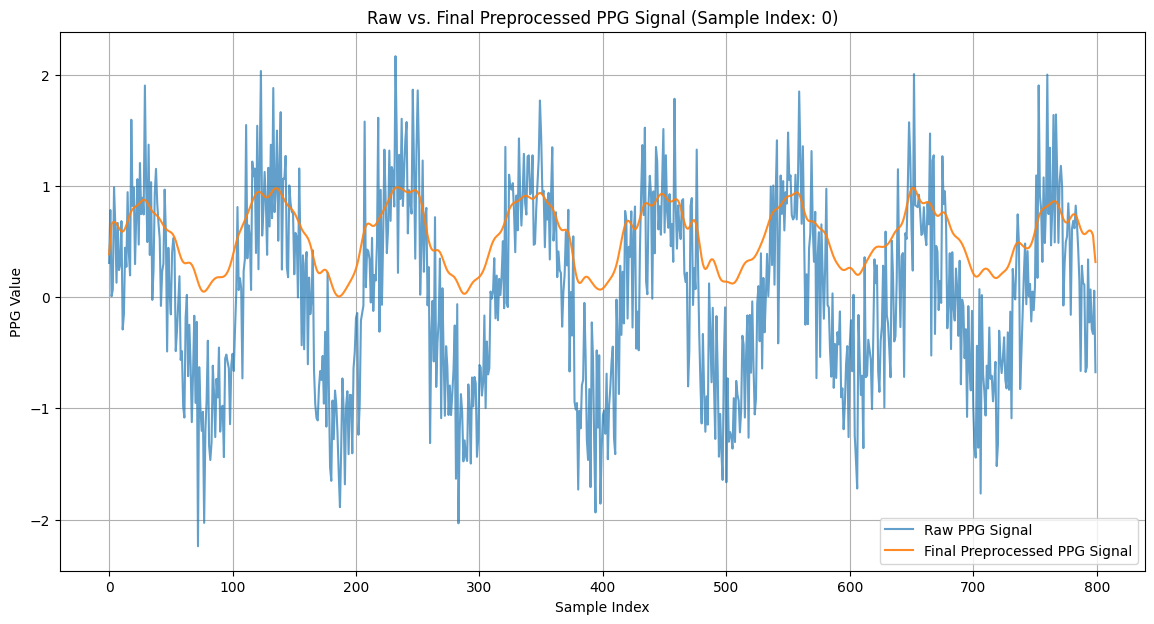

Displayed raw and final preprocessed signal for sample index 0.


In [22]:

sample_index = 0 #Frist sample
raw_signal_data = df_ppg.iloc[sample_index].to_numpy()

# Apply the complete preprocessing pipeline
processed_results = preprocess_ppg_signal(raw_signal_data, fs=100, verbose=False)

# Extract the raw and final preprocessed signals from the results
raw_signal_for_plot = processed_results['raw']
final_preprocessed_signal = processed_results['final']

# Plotting the raw and the final preprocessed signal
plt.figure(figsize=(14, 7))
plt.plot(raw_signal_for_plot, label='Raw PPG Signal', alpha=0.7)
plt.plot(final_preprocessed_signal, label='Final Preprocessed PPG Signal', alpha=0.9)

plt.title(f'Raw vs. Final Preprocessed PPG Signal (Sample Index: {sample_index})')
plt.xlabel('Sample Index')
plt.ylabel('PPG Value')
plt.legend()
plt.grid(True)
plt.show()

print(f"Displayed raw and final preprocessed signal for sample index {sample_index}.")

  
# Extract features from preprocessed PPG signal.
    
    Features include:
    - Statistical: mean, std, min, max, range
    - Peak-based: heart rate, peak count, peak prominence
    - Signal quality: SNR, peak regularity
    - Frequency domain: dominant frequency, spectral entropy
  

In [23]:


def extract_features(signal_data: np.ndarray, fs: int = 100) -> Dict[str, float]:

    features = {}

    # Statistical features
    features['mean'] = np.mean(signal_data)
    features['std'] = np.std(signal_data)
    features['min'] = np.min(signal_data)
    features['max'] = np.max(signal_data)
    features['range'] = features['max'] - features['min']
    features['peak_to_peak'] = np.ptp(signal_data)

    # Skewness and Kurtosis
    features['skewness'] = np.mean(((signal_data - features['mean']) / features['std']) ** 3)
    features['kurtosis'] = np.mean(((signal_data - features['mean']) / features['std']) ** 4)

    # Signal energy
    features['energy'] = np.sum(signal_data ** 2)
    features['power'] = features['energy'] / len(signal_data)

    # Peak detection for heart rate estimation
    # Find peaks with minimum distance of 0.5 seconds (minimum 30 BPM)
    min_distance = int(0.5 * fs)
    peaks, properties = find_peaks(signal_data, distance=min_distance, prominence=0.1)

    features['peak_count'] = len(peaks)

    if len(peaks) > 1:
        # Estimate heart rate from peaks
        avg_rr_interval = np.mean(np.diff(peaks)) / fs  # in seconds
        features['heart_rate'] = 60 / avg_rr_interval if avg_rr_interval > 0 else 0

        # Heart rate variability (SDNN - standard deviation of NN intervals)
        rr_intervals = np.diff(peaks) / fs
        features['hrv_sdnn'] = np.std(rr_intervals)

        # Peak regularity (coefficient of variation of RR intervals)
        features['peak_regularity'] = np.std(rr_intervals) / np.mean(rr_intervals) if np.mean(rr_intervals) > 0 else 0

        # Mean peak prominence
        features['mean_peak_prominence'] = np.mean(properties['prominences']) if 'prominences' in properties else 0
    else:
        features['heart_rate'] = 0
        features['hrv_sdnn'] = 0
        features['peak_regularity'] = 0
        features['mean_peak_prominence'] = 0

    # Frequency domain features
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)))
    features['dominant_frequency'] = freqs[np.argmax(psd)]

    # Spectral entropy (measure of signal complexity)
    psd_norm = psd / np.sum(psd)
    features['spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))

    # SNR estimation (signal power in cardiac band vs total)
    cardiac_band = (freqs >= 0.5) & (freqs <= 3.0)  # 30-180 BPM
    signal_power = np.sum(psd[cardiac_band])
    total_power = np.sum(psd)
    features['snr_estimate'] = 10 * np.log10(signal_power / (total_power - signal_power + 1e-10))

    # Zero crossing rate
    zero_crossings = np.sum(np.diff(np.sign(signal_data - np.mean(signal_data))) != 0)
    features['zero_crossing_rate'] = zero_crossings / len(signal_data)

    return features



# VISUALIZATION FUNCTIONS

In [52]:


def plot_preprocessing_steps(results: Dict[str, np.ndarray], fs: int = 100,
                             segment_id: str = ""):
    """
    Visualize all preprocessing steps in a single figure.
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(f'PPG Signal Preprocessing Steps - Segment {segment_id}', fontsize=16)

    time = np.arange(len(results['raw'])) / fs

    steps = [
        ('raw', 'Raw Signal'),
        ('detrended', 'After Detrending'),
        ('bandpassed', 'After Bandpass (0.5-8 Hz)'),
        ('notched', 'After Notch Filter (50 Hz)'),
        ('normalized', 'After Normalization'),
        ('final', 'Final Processed Signal')
    ]

    for idx, (key, title) in enumerate(steps):
        ax = axes[idx // 2, idx % 2]
        ax.plot(time, results[key], linewidth=1)
        ax.set_title(title)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_signal_with_peaks(signal_data: np.ndarray, fs: int = 100,
                           segment_id: str = ""):

    time = np.arange(len(signal_data)) / fs

    # Detect peaks
    min_distance = int(0.5 * fs)
    peaks, properties = find_peaks(signal_data, distance=min_distance, prominence=0.1)

    plt.figure(figsize=(15, 4))
    plt.plot(time, signal_data, label='Processed Signal', linewidth=1.5)
    plt.plot(time[peaks], signal_data[peaks], 'ro', label=f'Detected Peaks (n={len(peaks)})', markersize=8)

    if len(peaks) > 1:
        avg_rr = np.mean(np.diff(peaks)) / fs
        hr = 60 / avg_rr
        plt.title(f'Segment {segment_id} - Heart Rate ≈ {hr:.1f} BPM')
    else:
        plt.title(f'Segment {segment_id} - Insufficient peaks detected')

    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()


def process_dataset(df: pd.DataFrame, fs: int = 100) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Process entire dataset and extract features.

    Args:
        df: DataFrame with 'id', 'signal', 'label' columns
        fs: Sampling frequency

    Returns:
        processed_signals: DataFrame with processed signals
        features_df: DataFrame with extracted features
    """
    processed_signals = []
    all_features = []

    for idx, row in df.iterrows():
        signal_data = np.array([float(x) for x in row['signal'].split()])

        # Preprocess
        results = preprocess_ppg_signal(signal_data, fs=fs, verbose=False)

        # Extract features
        features = extract_features(results['final'], fs=fs)
        features['id'] = row['id']
        features['label'] = row['label']

        processed_signals.append({
            'id': row['id'],
            'raw_signal': signal_data,
            'processed_signal': results['final'],
            'label': row['label']
        })

        all_features.append(features)

    return pd.DataFrame(processed_signals), pd.DataFrame(all_features)

# Example
if __name__ == "__main__":


    # Example usage with synthetic data
    fs = 100  # Sampling frequency
    duration = 8  # seconds
    t = np.linspace(0, duration, fs * duration)

    # Create synthetic PPG signal with noise
    heart_rate = 72  # BPM
    freq = heart_rate / 60  # Hz

    # Simulated clean PPG
    clean_ppg = np.sin(2 * np.pi * freq * t) + 0.3 * np.sin(2 * np.pi * 2 * freq * t)

    # Add noise
    noisy_ppg = clean_ppg + 0.2 * np.random.randn(len(t)) + 0.1 * np.sin(2 * np.pi * 50 * t)

    print("\nProcessing example signal...")
    print("-" * 70)

    # Process signal
    results = preprocess_ppg_signal(noisy_ppg, fs=fs, verbose=True)

    # Extract features
    print("\nExtracting features...")
    features = extract_features(results['final'], fs=fs)

    print("\nExtracted Features:")
    print("-" * 70)
    for key, value in features.items():
        print(f"{key:.<30} {value:.4f}")

    print("\n" + "=" * 70)
    print("Pipeline ready for use!")


Processing example signal...
----------------------------------------------------------------------
Starting PPG Signal Preprocessing Pipeline
Signal length: 800 samples (8.0 seconds)
--------------------------------------------------
Step 1: Detrending signal...
Step 2: Applying bandpass filter (0.5-8 Hz)...
Step 3: Applying notch filter (50 Hz)...
Step 4: Normalizing signal...
Step 5: Applying light smoothing...
--------------------------------------------------
Preprocessing complete!

Extracting features...

Extracted Features:
----------------------------------------------------------------------
mean.......................... 0.4886
std........................... 0.2728
min........................... 0.0081
max........................... 0.9947
range......................... 0.9866
peak_to_peak.................. 0.9866
skewness...................... -0.0163
kurtosis...................... 1.7735
energy........................ 250.5155
power......................... 0.3131
peak_co

# Prepring Extrated Features to make Models

In [26]:
processed_signals_df, features_df = process_dataset(df.copy(), fs=100)

print(f"Shape of features_df: {features_df.shape}")
print("\nFirst 5 rows of features_df:")
display(features_df.head())

Shape of features_df: (100, 21)

First 5 rows of features_df:


,mean,std,min,max,range,peak_to_peak,skewness,kurtosis,energy,power,...,heart_rate,hrv_sdnn,peak_regularity,mean_peak_prominence,dominant_frequency,spectral_entropy,snr_estimate,zero_crossing_rate,id,label
0,0.541671,0.279046,0.006280,0.988297,0.982017,0.982017,-0.160495,1.722216,297.019137,0.371274,...,56.910569,0.076692,0.072743,0.769869,0.781250,1.605410,12.333508,0.0200,seg_000,noisy
1,0.510295,0.263222,0.008920,0.997167,0.988248,0.988248,-0.040124,1.761570,263.749242,0.329687,...,47.430830,0.064485,0.050976,0.724537,0.781250,1.450626,7.926928,0.0175,seg_001,noisy
2,0.507546,0.293377,0.004079,0.992129,0.988050,0.988050,-0.027949,1.643731,274.938357,0.343673,...,54.193548,0.157545,0.142299,0.697755,0.781250,1.311865,10.763287,0.0175,seg_002,clean
3,0.494318,0.294100,0.002036,0.995342,0.993305,0.993305,-0.032913,1.635967,264.676603,0.330846,...,63.324538,0.042353,0.044699,0.751857,1.171875,1.343639,18.443053,0.0225,seg_003,clean
4,0.511479,0.301477,0.003557,0.998744,0.995187,0.995187,-0.019647,1.643517,281.999084,0.352499,...,69.587629,0.046135,0.053507,0.752578,1.171875,1.284605,24.552823,0.0250,seg_004,clean


# Data spliting

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separate features (X) and target variable (y)
X = features_df.drop(['id', 'label'], axis=1)
y = features_df['label']

# Encode categorical labels to numerical (e.g., 'clean': 0, 'noisy': 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Original labels: {label_encoder.inverse_transform([0, 1])}")

# Split the dataset into training and testing sets
# Using a 80/20 split and a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Original labels: ['clean' 'noisy']

Shape of X_train: (80, 19)
Shape of X_test: (20, 19)
Shape of y_train: (80,)
Shape of y_test: (20,)


#Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier model
# Using a fixed random_state for reproducibility
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

print("Completed")

Completed


In [47]:
from sklearn.metrics import accuracy_score, f1_score

# Predict labels on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print(f"RF Results:")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")


RF Results:
Accuracy: 0.95
F1 Score: 0.96


#Logistic Regression



In [30]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
# Using random_state for reproducibility and 'liblinear' solver for small datasets
model_lr = LogisticRegression(random_state=42, solver='liblinear')

# Train the model on the training data
model_lr.fit(X_train, y_train)

print("Completed")

Logistic Regression model trained successfully.


In [48]:
from sklearn.metrics import accuracy_score, f1_score

# Predict labels on the test set using the Logistic Regression model
y_pred_lr = model_lr.predict(X_test)

# Calculate accuracy for Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Calculate F1 score for Logistic Regression
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Logistic Regression Results:")
print(f"Accuracy: {accuracy_lr:.2f}")
print(f"F1 Score: {f1_lr:.2f}")

Logistic Regression Results:
Accuracy: 0.85
F1 Score: 0.86


# XGBoost


In [49]:
from xgboost import XGBClassifier

# Initialize the XGBoost Classifier model
# Using random_state for reproducibility
# use_label_encoder and eval_metric are set for compatibility with newer versions of XGBoost
model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
model_xgb.fit(X_train, y_train)

print("Completed")

Completed


In [50]:
from sklearn.metrics import accuracy_score, f1_score

# Predict labels on the test set using the XGBoost model
y_pred_xgb = model_xgb.predict(X_test)

# Calculate accuracy for XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Calculate F1 score for XGBoost
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost Model Evaluation Results:")
print(f"Accuracy: {accuracy_xgb:.2f}")
print(f"F1 Score: {f1_xgb:.2f}")

XGBoost Model Evaluation Results:
Accuracy: 1.00
F1 Score: 1.00


In [35]:
print("\n--- Model Performance Summary ---")
print(f"Random Forest Classifier:\n  Accuracy: {accuracy:.2f}\n  F1 Score: {f1:.2f}")
print(f"Logistic Regression:\n  Accuracy: {accuracy_lr:.2f}\n  F1 Score: {f1_lr:.2f}")
print(f"XGBoost Classifier:\n  Accuracy: {accuracy_xgb:.2f}\n  F1 Score: {f1_xgb:.2f}")


--- Model Performance Summary ---
Random Forest Classifier:
  Accuracy: 0.95
  F1 Score: 0.96
Logistic Regression:
  Accuracy: 0.85
  F1 Score: 0.86
XGBoost Classifier:
  Accuracy: 1.00
  F1 Score: 1.00


# Saving the model for Streamlit app

In [36]:
import joblib

# Save the trained XGBoost model
joblib.dump(model_xgb, 'xgboost_model.joblib')
print("XGBoost model saved as 'xgboost_model.joblib'")

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.joblib')
print("Label encoder saved as 'label_encoder.joblib'")

XGBoost model saved as 'xgboost_model.joblib'
Label encoder saved as 'label_encoder.joblib'


# Streamlit Application File



In [37]:
%%writefile streamlit_ppg_app.py

import streamlit as st

st.set_page_config(layout="wide")

st.title("PPG Signal Quality Classifier")
st.write("Upload your PPG signal data to classify its quality as clean or noisy.")



Writing streamlit_ppg_app.py


In [38]:
%%writefile -a streamlit_ppg_app.py

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')


# SIGNAL FILTERING FUNCTIONS

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def notch_filter(data, f0, Q, fs):
    nyquist = 0.5 * fs
    w0 = f0 / nyquist
    b, a = signal.iirnotch(w0, Q)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def detrend_signal(data):
    detrended_data = signal.detrend(data)
    return detrended_data

def smooth_signal(data, window_size):
    if window_size <= 0:
        return data
    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, window, mode='same')
    return smoothed_data

def normalize_signal(data):
    min_val = np.min(data)
    max_val = np.max(data)
    if max_val - min_val == 0:
        return np.zeros_like(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def standardize_signal(data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    if std_val == 0:
        return np.zeros_like(data)
    return (data - mean_val) / std_val


# COMPLETE PREPROCESSING PIPELINE


def preprocess_ppg_signal(data: np.ndarray, fs: int = 100,
                          verbose: bool = False) -> Dict[str, np.ndarray]:
    results = {'raw': data.copy()}

    if verbose:
        print("Starting PPG Signal Preprocessing Pipeline")
        print(f"Signal length: {len(data)} samples ({len(data)/fs:.1f} seconds)")
        print("-" * 50)

    detrended = detrend_signal(data)
    results['detrended'] = detrended

    bandpassed = bandpass_filter(detrended, lowcut=0.5, highcut=8.0, fs=fs, order=4)
    results['bandpassed'] = bandpassed

    notched = notch_filter(bandpassed, f0=50, Q=30, fs=fs)
    results['notched'] = notched

    normalized = normalize_signal(notched)
    results['normalized'] = normalized

    smoothed = smooth_signal(normalized, window_size=5)
    results['smoothed'] = smoothed
    results['final'] = smoothed

    if verbose:
        print("-" * 50)
        print("Preprocessing complete!")

    return results

# FEATURE EXTRACTION FUNCTIONS (Copied from notebook)


def extract_features(signal_data: np.ndarray, fs: int = 100) -> Dict[str, float]:
    features = {}

    # Statistical features
    features['mean'] = np.mean(signal_data)
    features['std'] = np.std(signal_data)
    features['min'] = np.min(signal_data)
    features['max'] = np.max(signal_data)
    features['range'] = features['max'] - features['min']
    features['peak_to_peak'] = np.ptp(signal_data)

    # Skewness and Kurtosis
    features['skewness'] = np.mean(((signal_data - features['mean']) / features['std']) ** 3)
    features['kurtosis'] = np.mean(((signal_data - features['mean']) / features['std']) ** 4)

    # Signal energy
    features['energy'] = np.sum(signal_data ** 2)
    features['power'] = features['energy'] / len(signal_data)

    # Peak detection for heart rate estimation
    min_distance = int(0.5 * fs)
    peaks, properties = find_peaks(signal_data, distance=min_distance, prominence=0.1)

    features['peak_count'] = len(peaks)

    if len(peaks) > 1:
        avg_rr_interval = np.mean(np.diff(peaks)) / fs
        features['heart_rate'] = 60 / avg_rr_interval if avg_rr_interval > 0 else 0

        rr_intervals = np.diff(peaks) / fs
        features['hrv_sdnn'] = np.std(rr_intervals)

        features['peak_regularity'] = np.std(rr_intervals) / np.mean(rr_intervals) if np.mean(rr_intervals) > 0 else 0

        features['mean_peak_prominence'] = np.mean(properties['prominences']) if 'prominences' in properties else 0
    else:
        features['heart_rate'] = 0
        features['hrv_sdnn'] = 0
        features['peak_regularity'] = 0
        features['mean_peak_prominence'] = 0

    # Frequency domain features
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)))
    features['dominant_frequency'] = freqs[np.argmax(psd)]

    # Spectral entropy
    psd_norm = psd / np.sum(psd)
    features['spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))

    # SNR estimation
    cardiac_band = (freqs >= 0.5) & (freqs <= 3.0)
    signal_power = np.sum(psd[cardiac_band])
    total_power = np.sum(psd)
    features['snr_estimate'] = 10 * np.log10(signal_power / (total_power - signal_power + 1e-10))

    # Zero crossing rate
    zero_crossings = np.sum(np.diff(np.sign(signal_data - np.mean(signal_data))) != 0)
    features['zero_crossing_rate'] = zero_crossings / len(signal_data)

    return features


# VISUALIZATION FUNCTIONS


def plot_preprocessing_steps(results: Dict[str, np.ndarray], fs: int = 100,
                             segment_id: str = ""):
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(f'PPG Signal Preprocessing Steps - Segment {segment_id}', fontsize=16)

    time = np.arange(len(results['raw'])) / fs

    steps = [
        ('raw', 'Raw Signal'),
        ('detrended', 'After Detrending'),
        ('bandpassed', 'After Bandpass (0.5-8 Hz)'),
        ('notched', 'After Notch Filter (50 Hz)'),
        ('normalized', 'After Normalization'),
        ('final', 'Final Processed Signal')
    ]

    for idx, (key, title) in enumerate(steps):
        ax = axes[idx // 2, idx % 2]
        ax.plot(time, results[key], linewidth=1)
        ax.set_title(title)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


Appending to streamlit_ppg_app.py


In [39]:
%%writefile -a streamlit_ppg_app.py

# ============================================================================
# LOAD DATA AND MODELS
# ============================================================================

@st.cache_data
def load_data():
    df = pd.read_csv("ML_eng/mock_ppg_dataset.csv")
    # Process 'signal' column similar to df_ppg
    df_ppg = df['signal'].str.split(' ', expand=True)
    df_ppg = df_ppg.apply(pd.to_numeric, errors='coerce')
    df_ppg = df_ppg.add_prefix('ppg_')
    df = pd.concat([df, df_ppg], axis=1)
    return df

@st.cache_resource
def load_model_and_encoder():
    model_xgb = joblib.load('xgboost_model.joblib')
    label_encoder = joblib.load('label_encoder.joblib')
    return model_xgb, label_encoder

df = load_data()
model_xgb, label_encoder = load_model_and_encoder()

fs = 100 # Sampling frequency, consistent with notebook

Appending to streamlit_ppg_app.py


In [40]:
%%writefile -a streamlit_ppg_app.py


# STREAMLIT UI


st.sidebar.header("Signal Selection")
segment_ids = df['id'].tolist()
selected_segment_id = st.sidebar.selectbox(
    "Select a PPG Segment ID",
    segment_ids
)

# Get the raw signal data for the selected segment
selected_row = df[df['id'] == selected_segment_id].iloc[0]
raw_signal_data = selected_row.filter(like='ppg_').to_numpy().astype(float)

st.header(f"Analysis for Segment ID: {selected_segment_id}")
st.subheader("Raw PPG Signal")
fig_raw, ax_raw = plt.subplots(figsize=(12, 4))
ax_raw.plot(raw_signal_data)
ax_raw.set_xlabel("Sample Index")
ax_raw.set_ylabel("Amplitude")
ax_raw.set_title("Raw PPG Signal")
st.pyplot(fig_raw)



Appending to streamlit_ppg_app.py


In [41]:
%%writefile -a streamlit_ppg_app.py

# Apply preprocessing and extract features
processed_results = preprocess_ppg_signal(raw_signal_data, fs=fs, verbose=False)
extracted_features = extract_features(processed_results['final'], fs=fs)

# Convert extracted features to a DataFrame for display
features_df_display = pd.DataFrame([extracted_features]).T.rename(columns={0: "Value"})



Appending to streamlit_ppg_app.py


In [42]:
%%writefile -a streamlit_ppg_app.py

st.subheader("Preprocessing Steps")
st.pyplot(plot_preprocessing_steps(processed_results, fs=fs, segment_id=selected_segment_id))

st.subheader("Extracted Features")
st.dataframe(features_df_display)

Appending to streamlit_ppg_app.py


In [43]:
%%writefile -a streamlit_ppg_app.py

# Make prediction using the trained model
# The model expects a 2D array, so convert the single row of features
features_for_prediction = pd.DataFrame([extracted_features])
prediction_numeric = model_xgb.predict(features_for_prediction)

# Convert numerical prediction back to original label
prediction_label = label_encoder.inverse_transform(prediction_numeric)[0]

st.subheader("Signal Quality Prediction")
if prediction_label == 'clean':
    st.success(f"Predicted Quality: **{prediction_label.upper()}**")
else:
    st.error(f"Predicted Quality: **{prediction_label.upper()}**")

st.markdown("--- ")
st.markdown("**Note:** This application demonstrates PPG signal preprocessing, feature extraction, and classification. The model's performance on this dataset is highly accurate, but real-world performance may vary.")

Appending to streamlit_ppg_app.py


In [51]:
from google.colab import auth
auth.authenticate_user()
